<a href="https://colab.research.google.com/github/annycruzsalcedo/2023-Predictive-Analytics/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1: Define the Problem

In [1]:
# In this notebook we use a neural network to do a sentiment analysis about Apple product reviews.

#Task 2a: Install the Needed Libraries

In [2]:
#N/A

#Task 2b: Import the Needed Libraries

In [3]:
import itertools
import pandas as pd
import numpy as np
import string
import nltk
import nltk.corpus
import sklearn
import csv
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk import NaiveBayesClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from keras.models import load_model

# tokenize the dataset corpus, delete uncommon words such as names
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence
from IPython.display import display, HTML
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, accuracy_score, f1_score,recall_score, roc_auc_score,precision_recall_curve, average_precision_score, auc, roc_curve
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import classification_report

from keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pickle

sns.set()

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#Task 3: Load the Data

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/annycruzsalcedo/2023-Predictive-Analytics/main/Apple-Twitter-Sentiment-DFE.csv', encoding='ISO-8859-1')


#Task 4: Perform Data Exploratory Analysis (EDA)

##Show the data

In [6]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [7]:
data.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
3881,623499442,True,golden,13,NaN,3,0.7757,Tue Dec 09 22:08:53 +0000 2014,5.420000e+17,#AAPL OR @Apple,5\n3,(Via FC) Apple Is Warming Up To Social Media -...
3882,623499450,True,golden,16,NaN,3,0.6225,Tue Dec 09 22:18:27 +0000 2014,5.420000e+17,#AAPL OR @Apple,3\n1,RT @MMLXIV: there is no avocado emoji may I as...
3883,623499486,True,golden,14,NaN,5,0.9347,Tue Dec 09 23:45:59 +0000 2014,5.420000e+17,#AAPL OR @Apple,5,@marcbulandr I could not agree more. Between @...
3884,623499514,True,golden,13,NaN,1,0.9230,Wed Dec 10 00:48:10 +0000 2014,5.420000e+17,#AAPL OR @Apple,1,My iPhone 5's photos are no longer downloading...
3885,623517290,True,golden,17,NaN,5,0.8938,Tue Dec 09 09:01:25 +0000 2014,5.420000e+17,#AAPL OR @Apple,5\n3\nnot_relevant,RT @SwiftKey: We're so excited to be named to ...


##Get Data Info

In [8]:
data.describe()

,_unit_id,_trusted_judgments,sentiment:confidence,id
count,3.886000e+03,3886.000000,3886.000000,3.886000e+03
mean,6.234975e+08,3.687082,0.829526,5.410039e+17
std,1.171906e+03,2.004595,0.175864,7.942752e+14
min,6.234955e+08,3.000000,0.332700,5.400000e+17
25%,6.234965e+08,3.000000,0.674475,5.400000e+17
50%,6.234975e+08,3.000000,0.811250,5.410000e+17
75%,6.234984e+08,3.000000,1.000000,5.420000e+17
max,6.235173e+08,27.000000,1.000000,5.420000e+17


In [9]:
data['sentiment'].value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

##Find Missing Values

In [10]:
# How many reviews we have
print('There are', data.shape[0], 'reviews')

# check for duplicates
print("There are", len(data[data.duplicated()]), "duplicates")

# check if we have missing values
print("There are", data.isnull().sum().sum(), "missing values")

There are 3886 reviews
There are 0 duplicates
There are 3886 missing values


In [11]:
data.isnull().sum()

_unit_id                   0
_golden                    0
_unit_state                0
_trusted_judgments         0
_last_judgment_at        103
sentiment                  0
sentiment:confidence       0
date                       0
id                         0
query                      0
sentiment_gold          3783
text                       0
dtype: int64

#Task 5: Perform Data Cleaning

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [13]:
non_integer_values = data[~data['sentiment'].astype(str).str.isdigit()]

# Display the rows with non-integer values
print(non_integer_values)

       _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
17    623495530    False   finalized                   3     12/12/14 3:38   
20    623495533    False   finalized                   3    12/11/14 20:31   
75    623495588    False   finalized                   3    12/11/14 18:42   
106   623495619    False   finalized                   6    12/11/14 21:01   
115   623495628    False   finalized                   6     12/12/14 5:25   
...         ...      ...         ...                 ...               ...   
3578  623499108    False   finalized                   3    12/12/14 20:00   
3611  623499141    False   finalized                   6    12/12/14 10:31   
3650  623499180    False   finalized                   3    12/12/14 22:01   
3664  623499194    False   finalized                   3    12/11/14 21:03   
3879  623499409    False   finalized                   6    12/11/14 20:50   

         sentiment  sentiment:confidence                       

In [14]:
not_relevant_count = data['sentiment'].value_counts().get('not_relevant', 0)

print(f"Number of rows with 'not_relevant' in the 'sentiment' column: {not_relevant_count}")

Number of rows with 'not_relevant' in the 'sentiment' column: 82


In [15]:
data['sentiment'] = data['sentiment'].replace('not_relevant', pd.NA)

In [16]:
# Drop rows with missing values in the 'sentiment' column
data.dropna(subset=['sentiment'], inplace=True)

In [17]:
data['sentiment'] = data['sentiment'].astype('int64')

In [18]:
data = data[['sentiment:confidence', 'text', 'sentiment']].copy()

In [19]:
data.head()

,sentiment:confidence,text,sentiment
0,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,1.0000,My cat only chews @apple cords. Such an #Apple...,3
3,0.5848,I agree with @jimcramer that the #IndividualIn...,3
4,0.6474,Nobody expects the Spanish Inquisition #AAPL,3


In [20]:
#remaning 'sentiment' column to rating
data.rename(columns={'sentiment': 'rating'}, inplace=True)

#Task 6: Visualize Cleaned up Dataset

In [21]:
data.columns

Index(['sentiment:confidence', 'text', 'rating'], dtype='object')

In [22]:
data.isnull().sum()

sentiment:confidence    0
text                    0
rating                  0
dtype: int64

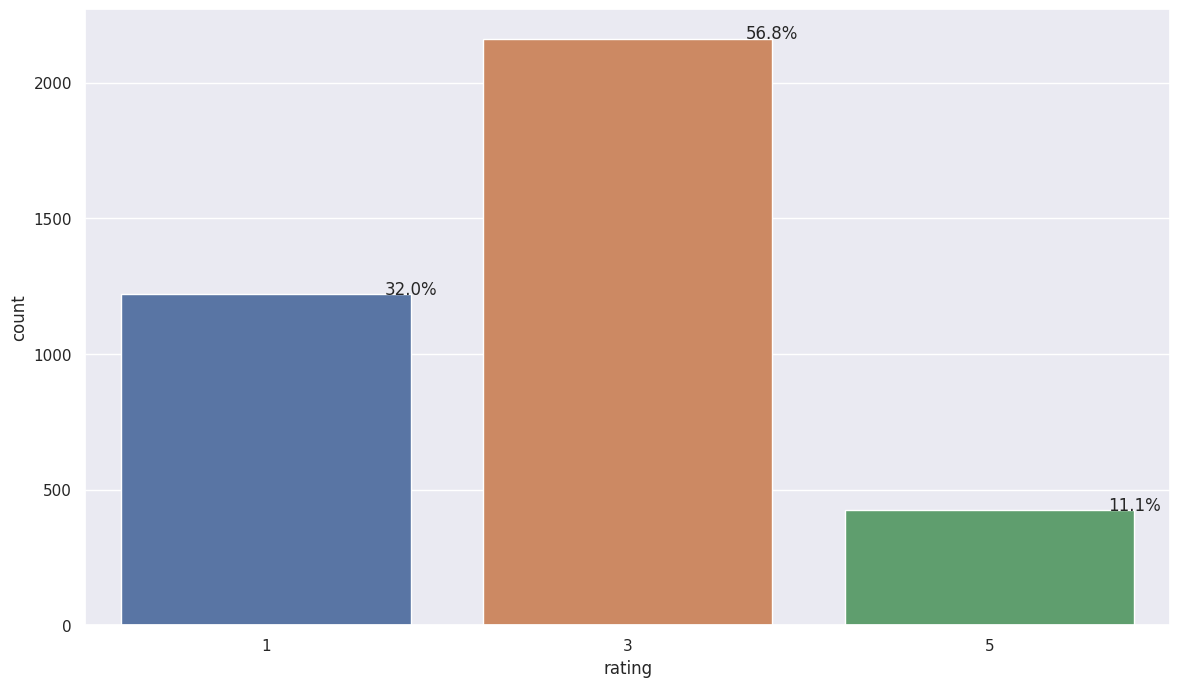

In [23]:
plt.figure(figsize=(14,8))
total = float(len(data))
ax = sns.countplot(x="rating", data=data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

#Task 7: Conceptualize the problem

In [24]:
# The ratings were either 1, 3 or 5. We could say that the were Negative, Neutral or Positive.

#Task 8: Perform Data-Split

In [25]:
categories = pd.DataFrame(data['rating'].apply(lambda x: 1 if x == 1 else (3 if x == 3 else 0)).to_numpy())

In [26]:
# create new  column called sentiment and store the pos for rate of 5, neutral for rate of 3 and negative for the rest
data['sentiment'] = data['rating'].apply(lambda x: "Negative" if x == 1 else ("Neutral" if x == 3 else "Positive"))
data.head()

,sentiment:confidence,text,rating,sentiment
0,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...,3,Neutral
1,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3,Neutral
2,1.0000,My cat only chews @apple cords. Such an #Apple...,3,Neutral
3,0.5848,I agree with @jimcramer that the #IndividualIn...,3,Neutral
4,0.6474,Nobody expects the Spanish Inquisition #AAPL,3,Neutral


In [27]:
data.head()

,sentiment:confidence,text,rating,sentiment
0,0.6264,#AAPL:The 10 best Steve Jobs emails ever...htt...,3,Neutral
1,0.8129,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3,Neutral
2,1.0000,My cat only chews @apple cords. Such an #Apple...,3,Neutral
3,0.5848,I agree with @jimcramer that the #IndividualIn...,3,Neutral
4,0.6474,Nobody expects the Spanish Inquisition #AAPL,3,Neutral


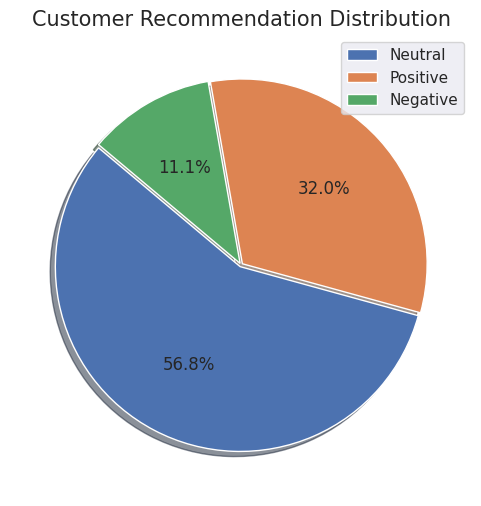

In [28]:
categories = data['sentiment'].unique()
explode = [0.01] * len(categories)

plt.figure(figsize=(6, 6))
plt.pie(data['sentiment'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels=categories)
plt.title('Customer Recommendation Distribution', fontsize=15)
plt.axis('off')
plt.show()

In [29]:
# For NLP we will keep only the necessary columns such as "rating", "text" and "sentiment" columns and we will drop the rest
data.drop(["sentiment:confidence"], axis = 1, inplace = True)

In [30]:
data.head()

,text,rating,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3,Neutral
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3,Neutral
2,My cat only chews @apple cords. Such an #Apple...,3,Neutral
3,I agree with @jimcramer that the #IndividualIn...,3,Neutral
4,Nobody expects the Spanish Inquisition #AAPL,3,Neutral


#Task 9: Choose the ML Method to follow

In [31]:
# create lemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
# function to get the simpler virsion of pos tag  to use  in lemmitazation
def get_simple_pos(tag):
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [33]:
def clean_reviews(review):
    clean_words=[]
    # Remove email addresses patterns
    raw_review = re.sub('\b[\w\-.]+?@\w+?\w+?\.\w{2,4}\b'," ", review)
    # Remove URLs  patterns
    raw_review =re.sub("[^a-zA-Z]"," ", raw_review)
    #Remove numbers
    raw_review= re.sub("\d+(\.\d+)?"," ", raw_review)

    stop_words=set(stopwords.words("english"))
    words_tokens= nltk.word_tokenize(raw_review)
    for word in words_tokens :

      if word.lower() not in stop_words:
        pos = pos_tag([word]) # get the part of speech of each word

        clean_word=(lemmatizer.lemmatize(word.lower(), pos=get_simple_pos(tag)) for word, tag in pos)
        clean_words.append("".join(clean_word))

    return (" ".join(clean_words))

In [34]:
# store the cleaned reviews inside clean_reviews_corpus array
clean_reviews_corpus = []

for review in data["text"]:
    clean_reviews_corpus.append(clean_reviews(review))

In [35]:
data["text"] = data["text"].apply(clean_reviews)
data["text"].head()

0       aapl best steve job email ever http co g kl tx
1    rt jpdesloges aapl stock mini flash crash toda...
2                        cat chew apple cord applesnob
3    agree jimcramer individualinvestor trade apple...
4               nobody expect spanish inquisition aapl
Name: text, dtype: object

In [36]:
data.head()

,text,rating,sentiment
0,aapl best steve job email ever http co g kl tx,3,Neutral
1,rt jpdesloges aapl stock mini flash crash toda...,3,Neutral
2,cat chew apple cord applesnob,3,Neutral
3,agree jimcramer individualinvestor trade apple...,3,Neutral
4,nobody expect spanish inquisition aapl,3,Neutral


In [37]:
print("review 25 cleaned {",data["text"][19],"}")

review 25 cleaned { aapl stock mini flash crash today money morning nothing analyst suggest would make widel http co jfgssy ei }


In [38]:
words_values = pd.Series(" ".join(data["text"]).split()).value_counts()
print(words_values)
rare_words = words_values[words_values <= 3]
print(rare_words)
print(rare_words.value_counts())

apple         3940
co            2275
http          2264
aapl          1321
rt             843
              ... 
hfvauozsox       1
pei              1
ofam             1
fcocuengin       1
unhelpful        1
Length: 7736, dtype: int64
audience      3
underway      3
sv            3
qhpim         3
jimmy         3
             ..
hfvauozsox    1
pei           1
ofam          1
fcocuengin    1
unhelpful     1
Length: 6309, dtype: int64
1    4827
2    1043
3     439
dtype: int64


In [39]:
data["text"] = data["text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
data["text"].head()

0             aapl best steve job email ever http co g
1    rt jpdesloges aapl stock mini flash crash toda...
2                                       cat apple cord
3      agree jimcramer trade apple aapl today good see
4                                          expect aapl
Name: text, dtype: object

In [40]:
# Create function to display wordcload
def create_WordCloud(data, back_ground_color = "black", title = None):
  wordcloud = WordCloud(background_color=back_ground_color, max_words=300, max_font_size=30 , scale=3,random_state=1).generate(str(data))
  mpl.rcParams['figure.figsize']=(15,15)
  mpl.rcParams['font.size']=20
  #plt.style.use('fast')
  fig = plt.figure(1)
  if title:
    plt.title(title, fontsize= 30)

  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

In [41]:
# separate the pos, neutral and neg words
Negative_words = []
Positive_words = []
Neutral_words = []

for label, text in zip(data["sentiment"], data["text"]):
    if label == 'Negative':
        Negative_words.append(text)
    elif label == 'Neutral':
        Neutral_words.append(text)
    else:
        Positive_words.append(text)

In [42]:
Negative_words[:20]

['wtf battery one second ago wtf apple',
 'apple contact sync yosemite io seriously screw use much past icloud',
 'buy iphone apple iphone use verizon network',
 'apple love center damn calendar app fix back center http co',
 'get storage almost full notification literally every minute apple',
 'make switch iphone galaxy note apple keep http co n',
 'rt stand apple sticker bought ipod',
 'flash crash really screw lot trader today im determine ever make trading work aapl',
 'nigga update yall headphone apple',
 'rt thehill justice department cite th century federal law get apple unlock iphones http co eth qpaiom',
 'ok apple win use browser anymore since keep literally time today',
 'thehill apple cite u judge pas law power',
 'apple u need get ur fuck shit together let youtube',
 'thehill apple wish could privacy search',
 'aapl apple drop http co',
 'hey apple fuck',
 'apple people explain buying laptop',
 'die hard apple customer must say truly displeased customer service give today 

In [43]:
Positive_words[:20]

['top apple tablet damn right http co',
 'cnbctv apple margin well expect aapl http co',
 'rt bought apple store pretty good logo match wait install http co z',
 'latest apple product lead http co fj apple iphone ipad',
 'rt apple thanks think upgrade',
 'photo love io apple iphone love io iphone young phone screen http co',
 'update gb apple guy like take money dammit look good',
 'apple io user account online sale x android user business sale cybermonday',
 'apple please new phone christmas',
 'well apple http co',
 'thank apple',
 'rt thank apple',
 'apple love product power cord junk seriously need fix',
 'aapl rt apple share benefit billion http co',
 'even apple watch raise aapl price target http co aapl alex',
 'love airmiles amp apple earn sale cybermonday',
 'surface maybe good product never well apple macbook air fact',
 'netflix apple tim cook great news hope wifi get sort though',
 'apple photo http co',
 'service today apple store thanks amp sort battery problem amp']

In [44]:
Neutral_words[:20]

['aapl best steve job email ever http co g',
 'rt jpdesloges aapl stock mini flash crash today aapl aapl http co e',
 'cat apple cord',
 'agree jimcramer trade apple aapl today good see',
 'expect aapl',
 'aapl stock buy december gain apple http co',
 'apple inc flash crash need know http co aapl',
 'aapl show make world biggest tech company http co',
 'apple watch top search engine list best wearable tech http co aapl iwatch applewatch',
 'best design iphone apps world accord apple http co http co',
 'aapl applenws thanks non dumb twitter stock drop point one minute thanks rumor',
 'apple thanks store appointment run almost minute late',
 'aapl stock mini flash crash today money morning nothing analyst suggest would make http co',
 'jh staff issue apple macbook ipad mini txed http co',
 'need ip portfolio defend big company look samsung apple court battle',
 'justice department cite th century federal law get apple unlock iphones http co eth qpaiom',
 'rt thehill justice department ci

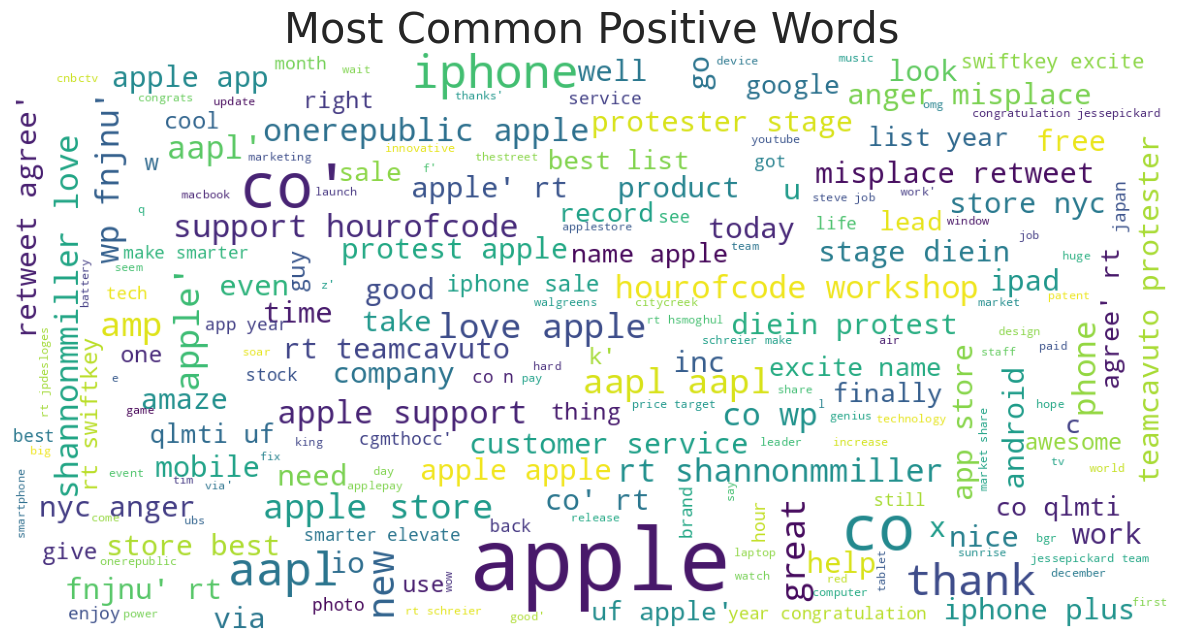

In [45]:
# wordcload for positive words
create_WordCloud(Positive_words, back_ground_color = "white", title = "Most Common Positive Words")

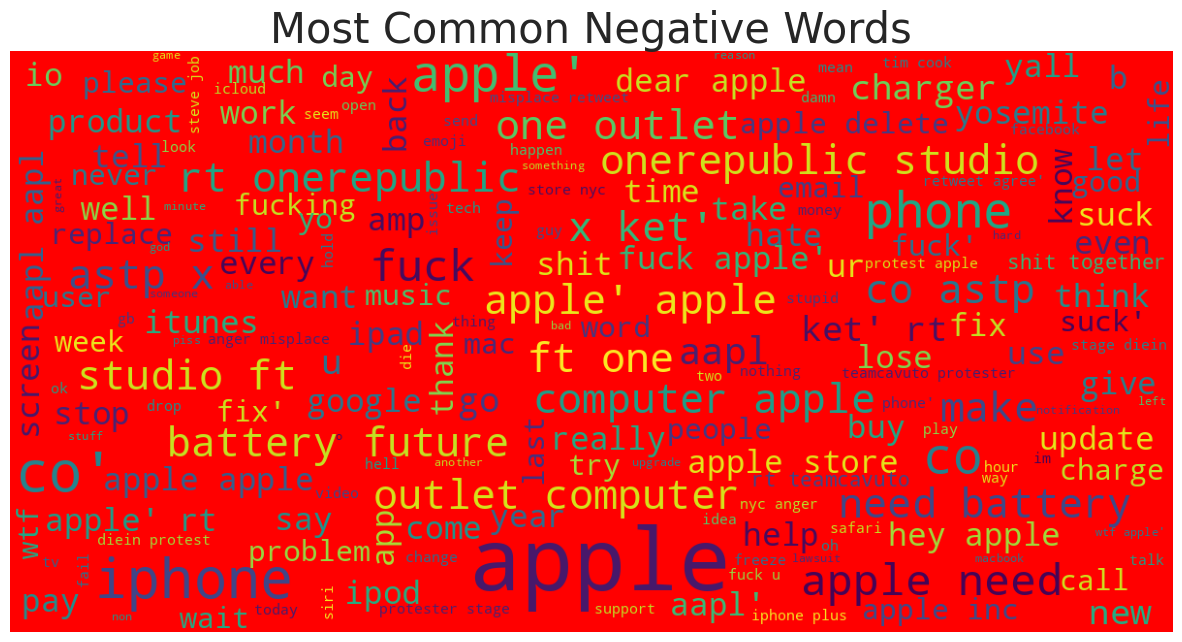

In [46]:
# wordcload for negative words
create_WordCloud(Negative_words, back_ground_color="red",title="Most Common Negative Words")

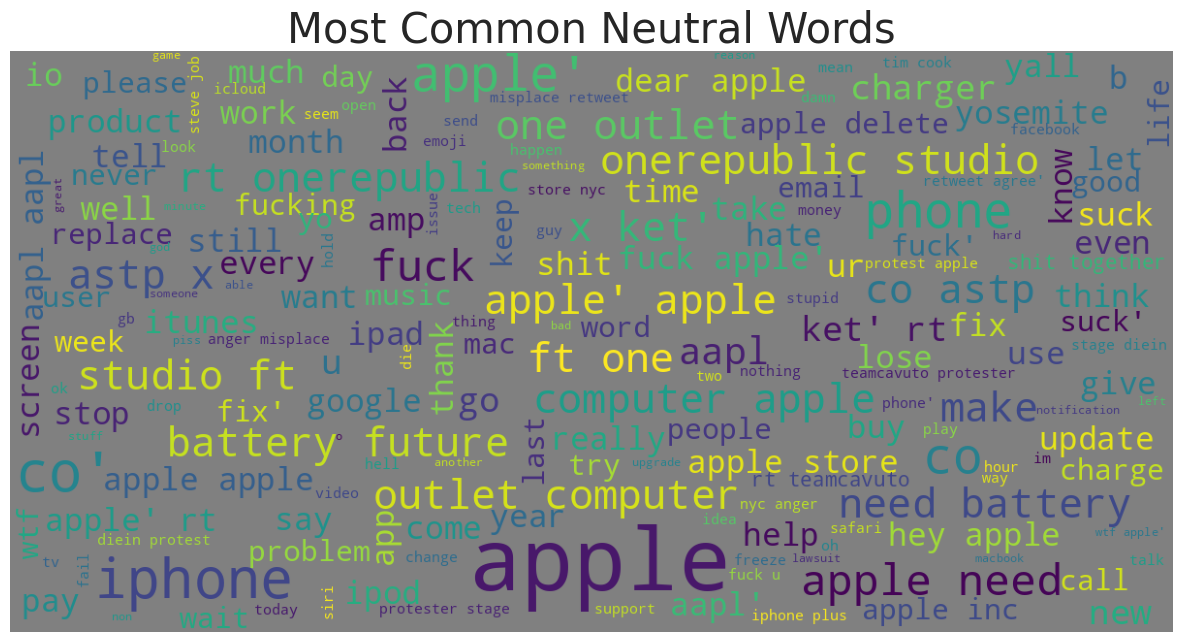

In [47]:
# wordcload for negative words
create_WordCloud(Negative_words, back_ground_color="gray",title="Most Common Neutral Words")

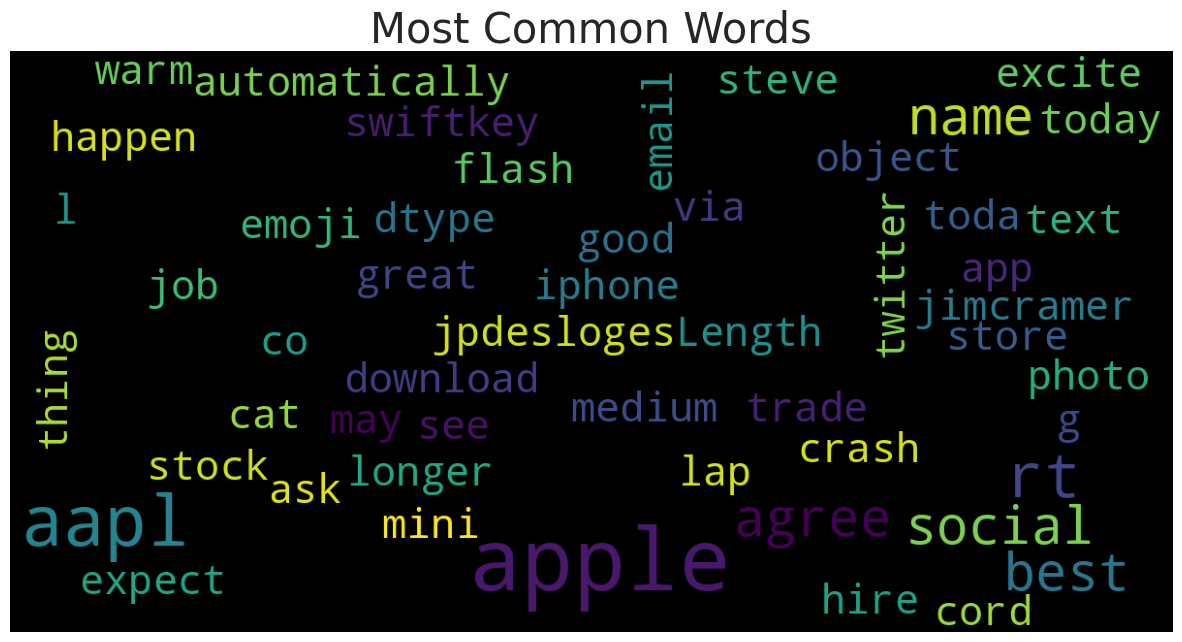

In [48]:
# wordcload for all words
create_WordCloud(data["text"], title = "Most Common Words")

In [49]:
# Top 15 words are in positive reviews
freq_pos = nltk.FreqDist(Positive_words)
freq_pos.most_common(15)

[('rt shannonmmiller love apple support hourofcode workshop http co wp fnjnu',
  19),
 ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree',
  12),
 ('rt swiftkey excite name apple app store best list year http co qlmti uf apple',
  7),
 ('rt schreier make smarter elevate apple app year congratulation jessepickard team http co r cgmthocc',
  5),
 ('onerepublic apple', 4),
 ('rt hsmoghul apple autocorrect change muslim awesome okay', 4),
 ('apple earns profit quarter amazon earn lifetime amazon apple http co', 3),
 ('thank apple', 2),
 ('apple new io excellent update phone http co', 2),
 ('goodbye graphic problem thank apple great customer service http co', 2),
 ('rt thestreet apple survive holiday investor say yes http co n k', 2),
 ('apple inc brand value jump company soar even http co aapl', 2),
 ('biggest difference mac pc yep stick mac apple http co apple', 2),
 ('top apple tablet damn right http co', 1),
 ('cnbctv apple margin well expect aap

In [50]:
# Top 15 words are in negative reviews
freq_neg=nltk.FreqDist(Negative_words)
freq_neg.most_common(10)

[('rt onerepublic studio ft one outlet computer apple need battery future http co astp x ket',
  71),
 ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree',
  12),
 ('rt cruci btch harry potter emojis please work apple', 7),
 ('fuck apple', 6),
 ('block trade detect aapl', 6),
 ('happy monday camera fancy apple iphone plus suddenly stop work weekend instead meme http co',
  5),
 ('rt ilovemymom try turn problem apple http co hysbbxpvz', 5),
 ('rt laura kate group message people apple', 4),
 ('rt vito sfam hey apple battery iphone drop like cock see gay porn xvideos main page fix shit',
  4),
 ('apple inc doom aapl drop currently price http co k aapl', 3)]

In [51]:
# Top 15 words are in neutral reviews
freq_neg=nltk.FreqDist(Neutral_words)
freq_neg.most_common(10)

[('rt onerepublic studio ft one outlet computer apple need battery future http co astp x ket',
  232),
 ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree',
  126),
 ('apple fibonacci technical level intraday update aapl aapl http co', 22),
 ('rt thehill justice department cite th century federal law get apple unlock iphones http co eth qpaiom',
  16),
 ('apple intraday comment update range premium user aapl stockaction trading stock mkt http co g tedlcb z',
  15),
 ('trade aapl free nightly update post twitter visit trade aapl free website http co u tkeapbxf',
  12),
 ('apple ceo tim cook come gay apple http co eufqqpmjj via posh net', 12),
 ('apple', 10),
 ('apple warm social medium apple hire social medium guru l apple finally tweet http co',
  9),
 ('block trade detect aapl', 8)]

# Deep Learning

#Task 10: Train

## Test, Train Split & Vectorization

In [52]:
# Create categorical variable 'categories' based on the 'rating' column
data['categories'] = pd.cut(data['rating'], bins=[0, 2, 4, 6], labels=['Negative', 'Neutral', 'Positive'])

# Convert the categories to numerical values (1, 2, 3)
data['categories'] = data['categories'].cat.codes + 1

# Construct the 'categories' DataFrame
categories = pd.DataFrame(data['categories'].to_numpy(), columns=['categories'])

In [53]:
# train-test-split
x_train, x_test, y_train, y_test = train_test_split(data["text"], categories, stratify = categories, test_size = 0.20, random_state = 42)

In [54]:
# Vectorization
# here we create new CountVectorizer, which will help us understand and count the words.
# and it has different ways to use it, but we will only use it with  2-3 gram
count_vec = CountVectorizer(ngram_range = (1,2))

In [55]:
# vectorizer to read the train text for us
x_train_features = count_vec.fit_transform(x_train)
x_train_features = x_train_features.toarray() # to get the frequincy of the words

In [56]:
x_test_features = count_vec.transform(x_test)

In [57]:
# https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d#:~:text=Term%20Frequency%20%E2%80%94%20Inverse%20Document%20Frequency%20(TFIDF)%20is%20a%20technique,in%20a%20document%20into%20consideration.

In [58]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_Tfid = tfidf_vectorizer.fit_transform(x_train)
X_test_Tfid = tfidf_vectorizer.transform(x_test)

In [59]:
X_train_Tfid.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.121564  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07410039, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13256994, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Deep Learning -- Neural Network

In [60]:
# find the length of the largest sentence in training data
max_len = max(x_train, key = len)
print(f'Max number of words in a text in training data: {len(max_len)}')

Max number of words in a text in training data: 118


In [61]:
# Convert reviews to padded sequences
max_words = 118
tokenizer = Tokenizer(num_words = max_words)

In [62]:
# create the vocabulary by fitting on X_train text
tokenizer.fit_on_texts(x_train)

In [63]:
# get the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(x_train)
xtest_seq = tokenizer.texts_to_sequences(x_test)

In [64]:
# padding the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=len(max_len))
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=len(max_len))
word_index = tokenizer.word_index

In [65]:
# get a random example
print('train review num 10:', x_train[9])
print('before padding:', xtrain_seq[9])
print('after padding:', xtrain_pad[9])

train review num 10: aapl show make world biggest tech company http co
before padding: [5, 75, 1, 111, 3, 2]
after padding: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   5  75   1 111   3   2]


In [66]:
# data shape after padding
print(xtrain_pad.shape)
print(xtest_pad.shape)
print(y_train.shape)
print(y_test.shape)

(3043, 118)
(761, 118)
(3043, 1)
(761, 1)


### Creating the network

In [67]:
def create_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Embedding(max_words, 100, input_length=max_words),
                                        tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, padding ='same', activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size = 2),
                                        tf.keras.layers.LSTM(256),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(3e-4), metrics=['accuracy'])
    return model

In [68]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 118, 100)          11800     
                                                                 
 conv1d (Conv1D)             (None, 118, 32)           6432      
                                                                 
 max_pooling1d (MaxPooling1  (None, 59, 32)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 314425 (1.20 MB)
Trainable params: 314425 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

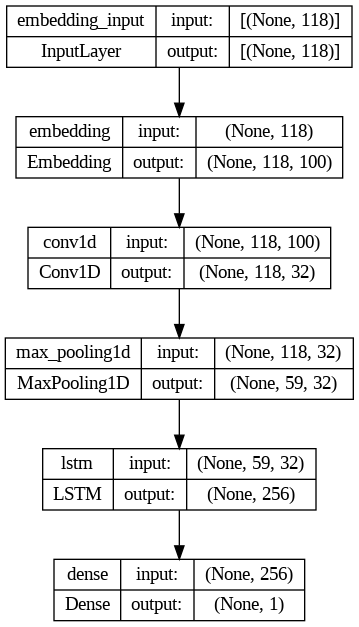

In [69]:
# print the block diagram of our model
plot_model(model, show_shapes = True, show_layer_names = True)

### Training the Network


In [70]:
# create model checkpoint and callbacks to save the model weights when validation accuracy is maximum
callback=tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 2, mode = 'auto', baseline = None, restore_best_weights = True)

In [71]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [72]:
# fit the model
with tf.device('/device:GPU:0'):
    history = model.fit(xtrain_pad, y_train, validation_data = (xtest_pad, y_test), class_weight = {0: 87, 1: 13}, epochs = 10, batch_size = 32)

Epoch 1/10


InvalidArgumentError: ignored

In [73]:
# predict probabilities for test set
y_probs = model.predict(xtest_pad, verbose = 0)

In [74]:
# predict classes for test set
y_classes = (model.predict(xtest_pad) > 0.5).astype("int32")
y_train_pred=(model.predict(xtrain_pad) >= 0.5).astype("int32")

96/96 [==============================] - 0s 4ms/step


In [75]:
# Model evaluation
train_nn_results = model.evaluate(xtrain_pad, y_train, verbose=0)
test_nn_results = model.evaluate(xtest_pad, y_test, verbose=0)
print(f'Train accuracy: {train_nn_results[1]*100:0.2f}')
print(f'Test accuracy: {test_nn_results[1]*100:0.2f}')

Train accuracy: 32.01
Test accuracy: 31.93


In [76]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
#The reviews cover a range of sentiments, negative, neutral or positive.
review_1 = "hey @apple fuck you"
review_2 = "@apple your chargers suck ass! They just love to break!"
review_3 = "I hate these @apple earphones so bad. Why in the world did they think it was a good idea to p http://t.co/X7lIGAQeG5 http://t.co/ihR2OGZa6s"
review_4 = ". @Apple is the Most Innovative Company of 2014 http://t.co/h4gqjPyluF via @TechCocktail #innovation"
review_5 = "I would like an @Apple rep to reach out to me and resolve the issue @tim_cook"
review_6 = "macbook love today @apple"

reviews = [review_1, review_2, review_3, review_4, review_5, review_6]


#Task 11: Test

In [78]:
results = {}
preds = []
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequences
    model_= load_model("my_model.h5")
    sequence = pad_sequences(sequence, maxlen = max_words)
    # get the prediction
    prediction = model_.predict(sequence)[0]
    if (np.round(prediction, 2) >= 0.5):
        pred = "Positive"
    else:
        pred = "Negative"
    return pred

In [79]:
for ind, review in enumerate(reviews):
    prediction = get_predictions(review)
    preds+=[prediction]
    results["CNN_LSTM_Model"] = preds

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 732ms/step


1/1 [==============================] - 1s 520ms/step


In [80]:
# df_reviews = pd.DataFrame(reviews, index=["Review 1", "Review 2"])
df_reviews = pd.DataFrame(reviews, index=["Review 1", "Review 2", "Review 3", "Review 4", "Review 5", "review 6"])

display(HTML(df_reviews.to_html()))

# df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Review 1", "Review 2"])
df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Review 1", "Review 2", "Review 3", "Review 4", "Review 5", "Review 6"])

df.style.set_table_styles([{"selector": ".row2,.row3,.row6", "props": [("border", "2px solid black"), ("color", "black"), ("background-color", "lightgreen")]},
                           {"selector": "thead", "props":"background-color:aqua; color:black; border:3px solid black;"}])

,0
Review 1,hey @apple fuck you
Review 2,@apple your chargers suck ass! They just love to break!
Review 3,I hate these @apple earphones so bad. Why in the world did they think it was a good idea to p http://t.co/X7lIGAQeG5 http://t.co/ihR2OGZa6s
Review 4,. @Apple is the Most Innovative Company of 2014 http://t.co/h4gqjPyluF via @TechCocktail #innovation
Review 5,I would like an @Apple rep to reach out to me and resolve the issue @tim_cook
review 6,macbook love today @apple


,Review 1,Review 2,Review 3,Review 4,Review 5,Review 6
CNN_LSTM_Model,Positive,Positive,Positive,Positive,Positive,Positive
